# [**Comparaison des régresseurs bayésiens linéaires**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/1_1_linear_model/plot_ard.ipynb)<br/>([_Comparing Linear Bayesian Regressors_](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ard.html))

Cet exemple compare deux types de régresseurs bayésiens :
- [**Détermination Automatique de la Pertinence (ARD)** (1.1.10.2)](https://scikit-learn.org/stable/modules/linear_model.html#automatic-relevance-determination)
- [**Régression Ridge Bayésienne** (1.1.10.1)](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression)

Dans la première partie, nous utilisons un modèle des [**moindres carrés ordinaires (OLS)** (1.1.1)](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) comme référence pour comparer les coefficients des modèles par rapport aux vrais coefficients. Ensuite, nous montrons que l'estimation de ces modèles est réalisée en maximisant itérativement la log-vraisemblance marginale des observations.

Dans la dernière section, nous traçons les prédictions et les incertitudes pour les régressions ARD et Ridge bayésiennes en utilisant une expansion des caractéristiques polynomiales pour ajuster une relation non linéaire entre `X` et `y`.

```python
# Author: Arturo Amor <david-arturo.amor-quiroz@inria.fr>
```

# Robustesse des modèles pour retrouver les poids réels

## Générer un jeu de données synthétique

Nous générons un jeu de données où `X` et `y` sont linéairement liés : 10 des caractéristiques de `X` seront utilisées pour générer `y`. Les autres caractéristiques ne sont pas utiles pour prédire `y`. De plus, nous générons un jeu de données où `n_samples == n_features`. Un tel paramétrage est un défi pour un modèle OLS et peut potentiellement conduire à des poids arbitrairement grands. Avoir un _a priori_ sur les poids et une pénalité atténue le problème. Enfin, du bruit gaussien est ajouté.

In [1]:
from sklearn.datasets import make_regression

X, y, true_weights = make_regression(
    n_samples=100,
    n_features=100,
    n_informative=10,
    noise=8,
    coef=True,
    random_state=42,
)

## Ajuster les régresseurs

Nous ajustons maintenant les deux modèles bayésiens et l'OLS pour comparer ultérieurement les coefficients des modèles.

In [2]:
import pandas as pd

from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression

olr = LinearRegression().fit(X, y)
brr = BayesianRidge(compute_score=True, n_iter=30).fit(X, y)
ard = ARDRegression(compute_score=True, n_iter=30).fit(X, y)
df = pd.DataFrame(
    {
        "Weights of true generative process": true_weights,
        "ARDRegression": ard.coef_,
        "BayesianRidge": brr.coef_,
        "LinearRegression": olr.coef_,
    }
)

c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(


## Tracer les coefficients réels et estimés

Maintenant, nous comparons les coefficients de chaque modèle avec les poids du vrai modèle générateur.

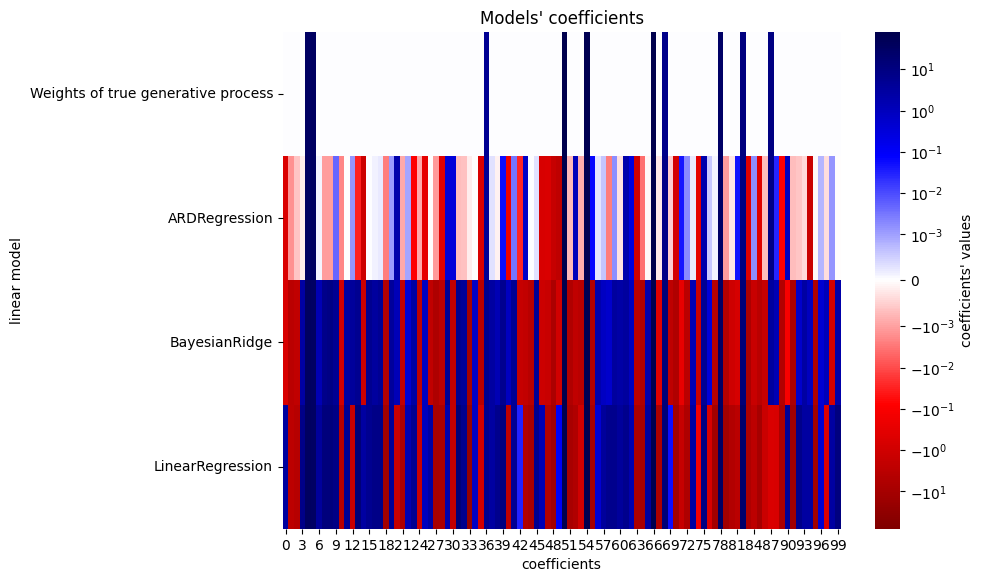

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import SymLogNorm

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    df.T,
    norm=SymLogNorm(linthresh=10e-4, vmin=-80, vmax=80),
    cbar_kws={"label": "coefficients' values"},
    cmap="seismic_r",
)
plt.ylabel("linear model")
plt.xlabel("coefficients")
plt.tight_layout(rect=(0, 0, 1, 0.95))
_ = plt.title("Models' coefficients")

En raison du bruit ajouté, aucun des modèles ne retrouve les poids réels. En effet, tous les modèles ont toujours plus de 10 coefficients non nuls. Comparativement à l'estimateur OLS, les coefficients obtenus avec une régression Ridge bayésienne sont légèrement déplacés vers zéro, ce qui les stabilise. La régression ARD fournit une solution plus parcimonieuse : certains des coefficients non informatifs sont mis exactement à zéro, tandis que d'autres sont déplacés plus près de zéro. Certains coefficients non informatifs sont toujours présents et conservent des valeurs importantes.

## Tracer la log-vraisemblance marginale

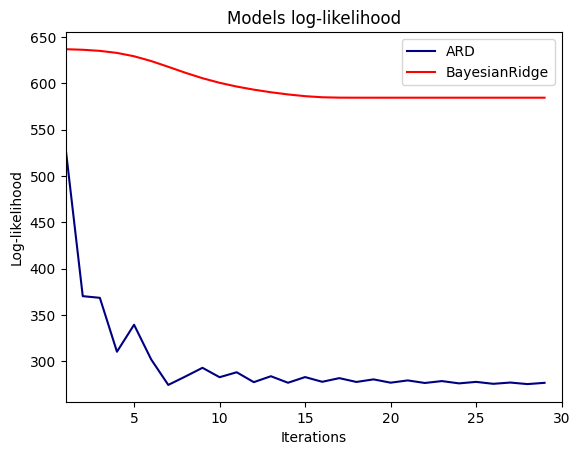

In [4]:
import numpy as np

ard_scores = -np.array(ard.scores_)
brr_scores = -np.array(brr.scores_)
plt.plot(ard_scores, color="navy", label="ARD")
plt.plot(brr_scores, color="red", label="BayesianRidge")
plt.ylabel("Log-likelihood")
plt.xlabel("Iterations")
plt.xlim(1, 30)
plt.legend()
_ = plt.title("Models log-likelihood")

En effet, les deux modèles minimisent la log-vraisemblance jusqu'à une coupure arbitraire définie par le paramètre n_iter.

# Régressions bayésiennes avec une expansion des caractéristiques polynomiales

## Générer un jeu de données synthétique

Nous créons une cible qui est une fonction non linéaire de la caractéristique d'entrée. Du bruit suivant une distribution uniforme standard est ajouté.

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

rng = np.random.RandomState(0)
n_samples = 110

# sort the data to make plotting easier later
X = np.sort(-10 * rng.rand(n_samples) + 10)
noise = rng.normal(0, 1, n_samples) * 1.35
y = np.sqrt(X) * np.sin(X) + noise
full_data = pd.DataFrame({"input_feature": X, "target": y})
X = X.reshape((-1, 1))

# extrapolation
X_plot = np.linspace(10, 10.4, 10)
y_plot = np.sqrt(X_plot) * np.sin(X_plot)
X_plot = np.concatenate((X, X_plot.reshape((-1, 1))))
y_plot = np.concatenate((y - noise, y_plot))

## Ajuster les régresseurs

Ici, nous essayons un polynôme de degré 10 pour potentiellement sur-ajuster, bien que les modèles linéaires bayésiens régularisent la taille des coefficients polynomiaux. Comme `fit_intercept=True` est la valeur par défaut pour [**`ARDRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html) et [**`BayesianRidge`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html), [**`PolynomialFeatures`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) ne devrait pas introduire de caractéristique de biais supplémentaire. En définissant `return_std=True`, les régresseurs bayésiens renvoient l'écart type de la distribution _a posteriori_ pour les paramètres du modèle.

In [6]:
ard_poly = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    StandardScaler(),
    ARDRegression(),
).fit(X, y)
brr_poly = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    StandardScaler(),
    BayesianRidge(),
).fit(X, y)

y_ard, y_ard_std = ard_poly.predict(X_plot, return_std=True)
y_brr, y_brr_std = brr_poly.predict(X_plot, return_std=True)

## Tracer les régressions polynomiales avec les erreurs types des scores

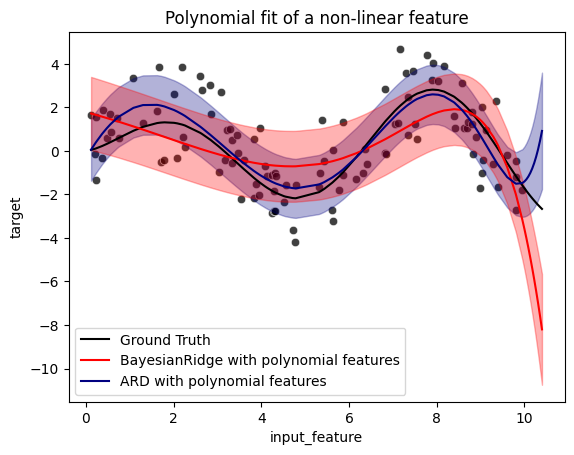

In [7]:
ax = sns.scatterplot(
    data=full_data, x="input_feature", y="target", color="black", alpha=0.75
)
ax.plot(X_plot, y_plot, color="black", label="Ground Truth")
ax.plot(X_plot, y_brr, color="red", label="BayesianRidge with polynomial features")
ax.plot(X_plot, y_ard, color="navy", label="ARD with polynomial features")
ax.fill_between(
    X_plot.ravel(),
    y_ard - y_ard_std,
    y_ard + y_ard_std,
    color="navy",
    alpha=0.3,
)
ax.fill_between(
    X_plot.ravel(),
    y_brr - y_brr_std,
    y_brr + y_brr_std,
    color="red",
    alpha=0.3,
)
ax.legend()
_ = ax.set_title("Polynomial fit of a non-linear feature")

Les barres d'erreur représentent un écart type de la distribution gaussienne prédite des points interrogés. Remarquez que la régression ARD capture le mieux la vérité fondamentale en utilisant les paramètres par défaut dans les deux modèles, mais réduire davantage le paramètre hypermédia `lambda_init` de la régression Ridge bayésienne peut réduire son biais (voir l'exemple [**Ajustement de courbe avec la régression Ridge bayésienne**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/1_1_linear_model/plot_bayesian_ridge_curvefit.ipynb)). Enfin, en raison des limites intrinsèques d'une régression polynomiale, les deux modèles échouent en extrapolation.